# PLSC 597 - Homework 4
### Maya Dalton (12/4/23)

Please find my Jupyter Notebook file and data file for this assignment [here.](https://github.com/mad6821/PLSC-597---Machine-Learning)


In [1]:
# Importing libraries, storing as shorthand
# pip install torch
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
import torch.optim as optim

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error, accuracy_score, classification_report, confusion_matrix


## Question 1

I utilized my MA thesis data derived from the Varieties of Democracy (VDEM) and Electoral Contention and Violence (ECAV) datasets. ECAV contains information on nonviolent and violent contention related 1,208 to national in 136 countries from 1990-2012. From VDEM, I derive a set of predictor variables of electoral violence. These variables include regime type, electoral system, political competition, international election monitoring, candidate restrictions, social group power opportunities, and gross domestic product (GDP). I compare two neural network models: (1) a single layer RNN, (2) a LSTM RNN. I plan to use this data to forecast electoral violence for the next year based on the best performing RNN model.

In [2]:
def load_data(): # Load in data and set X and y
    df = pd.read_csv('dalton_df.csv')
    # One-Hot Encoding for country variable
    df_encoded = pd.get_dummies(df, columns=['country'])
    X = df_encoded.drop('elect_vio', axis=1) # Predictors
    y = df_encoded['elect_vio'] # Conflict
    return X, y, df
    pass

def preprocess_data(X, y): # Scale X variable
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    return torch.tensor(X_scaled, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

In [3]:
X, y, df = load_data()

# Preprocess data
X_processed, y_processed = preprocess_data(X, y)

X_train, X_val, y_train, y_val = train_test_split(X_processed, y_processed, test_size=0.2, random_state=42)
y_train = np.array(y_train)

## Question 2
The first model is utilizes an RNN with a fully connected recurrent layer and a linear activation function. The second model is a long-term memory cell (LSTM) RNN model, also using a linear activation function. Both models' hidden layers have 64 neurons and the output layer utilizes a cross entropy loss function derived from the sigmoid function. I first define the training and evaluation function for the models, retaining their training history for further analysis. I then build each RNN model and compare their training loss and training and validation accuracy across multiple epochs.


In [4]:
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs): # train model, retain training loss
    train_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), targets.view(-1))
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            # Calculate training accuracy
            predictions = (outputs > 0.5).float()
            correct_train += (predictions.squeeze() == targets).sum().item()
            total_train += targets.size(0)

       # Record training loss and accuracy for this epoch
        train_losses.append(running_loss / len(train_loader))
        train_accuracy = correct_train / total_train
        train_accuracies.append(train_accuracy)

        # Validate the model
        model.eval()
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                predictions = (outputs > 0.5).float()
                correct_val += (predictions.squeeze() == labels).sum().item()
                total_val += labels.size(0)

        # Record validation accuracy for this epoch
        val_accuracy = correct_val / total_val
        val_accuracies.append(val_accuracy)

    return train_losses, train_accuracies, val_accuracies

In [43]:
# Single RNN Layer
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(RNN, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers=2, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        _, hidden = self.rnn(x)
        # Take the hidden state from the last layer
        out = hidden[-1, :, :]
        out = self.fc(out)
        return out

# Create DataLoader for training
train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32)[:, :, np.newaxis], torch.tensor(y_train, dtype=torch.float32)[:, np.newaxis])
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Create DataLoader for validation
val_dataset = TensorDataset(X_val.unsqueeze(2), y_val.unsqueeze(1))
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

# Instantiate the model, loss function, and optimizer
input_size = 96
hidden_size = 64
model1 = RNN(input_size, hidden_size)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model1.parameters(), lr=0.001)

<ipython-input-43-cfac2fc5f121>:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32)[:, :, np.newaxis], torch.tensor(y_train, dtype=torch.float32)[:, np.newaxis])


In [ ]:
train_losses, train_accuracies, val_accuracies = train_model(model1, train_loader, val_loader, criterion, optimizer, epochs=10)

plt.figure(figsize=(12, 4))

# Plot training loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
for inputs, targets in train_loader:
  print(inputs.shape)
  #print(inputs.shape[-1])
  #model(inputs)

As shown above in the left panel, the single-layer RNN's loss decreases gradually throughout the epochs, with an interesting jump after 8 epochs. This implies that the loss would either continue to increase with more epochs, or stabilize at around 0.580 training loss. Either way, the model performs better with more epochs.

On the right panel, the training accuracy also diminishes with more epochs. Because the model's accuracy is around 30-40%, this implies that it does not do well at recovering instances of electoral violence. Supportive to this is that the validation accuracy is very unstable, meaning that this model is likely overfitting my data.

In [44]:
# Define LSTM RNN
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(RNN, self).__init__()
        self.rnn = nn.LSTM(input_size, hidden_size, num_layers=2, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        # LSTM input: (batch_size, seq_len, input_size)
        _, (hidden, _) = self.rnn(x)
        # Take the hidden state from the last layer
        out = hidden[-1, :, :]
        out = self.fc(out)
        return out

#### LSTM RNN

# Create DataLoader for training
train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32)[:, :, np.newaxis], torch.tensor(y_train, dtype=torch.float32)[:, np.newaxis])
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Create DataLoader for validation
val_dataset = TensorDataset(X_val.unsqueeze(2), y_val.unsqueeze(1))
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

# Instantiate the model, loss function, and optimizer
input_size = X_processed.shape[1]
hidden_size = 64
model2 = RNN(input_size, hidden_size)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model2.parameters(), lr=0.001)

<ipython-input-44-45b1d1fbd557>:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32)[:, :, np.newaxis], torch.tensor(y_train, dtype=torch.float32)[:, np.newaxis])


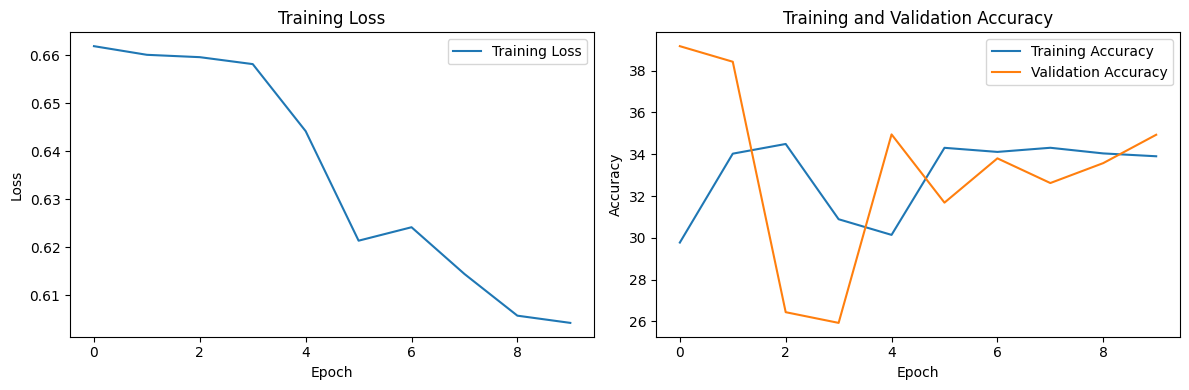

In [14]:
train_losses, train_accuracies, val_accuracies = train_model(model2, train_loader, val_loader, criterion, optimizer, epochs=10)
plt.figure(figsize=(12, 4))

# Plot training loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

The plots above show the loss and accuracy of the LSTM model. Intitially, these plots look better than the single-layer RNN. The left panel depicts a diminishing training loss across epochs, meaning the model is performing better with more batches. In the right panel, the training accuracy dips around 2 epochs, but increases to stabilize around 34% for the remaining. The validation accuracy increases and begins to converge with the training accuracy, meaning that the model performs well against unseen validation data and isn't necesarily overfitting as much as the previous model. Finally, the accuracy is a little bit smaller than the previous model, meaning it does not recover as many accuracy predictions of electoral violence. Even so, there is a trade off in convergence of the validation and training accuracy versus a low accuracy overall.

## Question 3
Because the LSTM RNN model performed best at recovering accurate predictions of electoral violence, I will use that model to predict instances of electoral violence. The LSTM RNN model predicts 588 cases of electoral violence out of 1528, with an accuracy score of 38%. While this is a low accuracy score, the model still provides a step in predicting electoral violence based on various predictor variables stated by the literature.

In [40]:
def predict_with_model(model, data_loader):
    model.eval()
    predictions = []

    with torch.no_grad():
        for inputs, in data_loader:  # Unpack the single-element tuple
            outputs = model(inputs)
            predictions.extend(outputs.squeeze().cpu().numpy())

    predictions = (np.array(predictions) > 0.5).astype(int)
    return predictions

In [47]:
test_dataset = TensorDataset(torch.tensor(X_val, dtype=torch.float32)[:, :, np.newaxis])
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
predictions = predict_with_model(model2, test_loader)

# Convert predictions and ground truth to numpy arrays
predictions_np = np.array(predictions)
y_val_np = y_val.numpy()

# Check if predictions are correct
correct_predictions = predictions_np == y_val_np
accuracy = np.sum(correct_predictions) / len(predictions_np)

print("Cases:", len(predictions_np))
print("Correct Predictions:", np.sum(correct_predictions))
print(f"Accuracy: {accuracy:.3f}")

<ipython-input-47-20b6f52bee5f>:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_dataset = TensorDataset(torch.tensor(X_val, dtype=torch.float32)[:, :, np.newaxis])


Cases: 1528
Correct Predictions: 588
Accuracy: 0.385
